In [2]:

from __future__ import division, unicode_literals
import pandas as pd
import pymysql
import pymssql
from sqlalchemy import create_engine
import re
import numpy as np
import statsmodels.api as sm
from scipy.stats import *
from sklearn import preprocessing
import datetime
import re

gdb = ''
ghost = ''
guser = ''
gpassword = ''
gdatabase = ''
conn = ''
engine = ''



def set_sql(gdb, ghost, guser, gpassword, gdatabase):
    global db, host, user, password, database, engine, conn
    db = gdb
    host = ghost
    user = guser
    password = gpassword
    database = gdatabase
    engine = set_engine()
    conn = set_conn()


def set_engine():
    global engine
    try:
        engine.close()
    except:
        pass
    if db.lower() == 'mysql':
        engine = create_engine('mysql+pymysql://' + user + ':' + password + '@' + host + '/' + database)
    if db.lower() == 'mssql':
        engine = create_engine('mssql+pyodbc://' + user + ':' + password + '@' + host + '/' + database)
    return engine



def set_conn():
    if db.lower() == 'mysql':
        conn = pymysql.connect(host=host, user=user, password=password, db=database, charset='utf8')
    if db.lower() == 'mssql':
        conn = pymssql.connect(host=host, user=user, password=password, database=database, charset="utf8")
    return conn


def execute_sql(sql_str, conn):
    cursor = conn.cursor()
    cursor.execute(sql_str)
    conn.commit()



def search_sql(sql_str):
    s = pd.read_sql(sql_str, conn)
    return s



def to_sql(df, table_name):
    try:
        df.to_sql(table_name, engine, if_exists='append')
    except IOError as e:
        print('to sql error! \n ' + e)

In [3]:
set_sql('mysql', '172.16.8.184', 'qc_data', 'wisesoe.qc', 'qc_data')

In [7]:
data = pd.read_csv('~/default.csv')

In [3]:
set_sql('mysql', '172.16.8.184', 'qc_data', 'wisesoe.qc', 'qc_data')

NameError: name 'set_sql' is not defined

In [2]:
indu = search_sql('select * from induindex')

NameError: name 'search_sql' is not defined

In [69]:
test = data[data['default_ann_date']>='2016-01-05']

In [1]:
indu

NameError: name 'indu' is not defined

In [18]:
hy ={'33':'制造业','34':'制造业','30':'制造业','25':'制造业','26':'制造业','60':'制造业','28':'制造业','27':'制造业',
     '22':'制造业','35':'卫生和社会工作','23':'建筑业','24':'建筑业','42':'房地产业','31':'批发和零售业','36':'批发和零售业',
    '63':'文化、体育和娱乐业','20':'电力、热力、燃气及水生产和供应业','40':'金融业','41':'金融业','11':'采矿业','12':'采矿业',
    '70':'综合','32':'住宿和餐饮业','50':'交通运输、仓储和邮政业','60':'信息传输、软件和信息技术服务业',
    '61':'信息传输、软件和信息技术服务业','62':'信息传输、软件和信息技术服务业','37':'农、林、牧、渔业','10':'采矿业','21':'采矿业'}



In [52]:
indu['code'] = indu['indu'].map(hy)

In [48]:
group = indu.groupby('code')

In [62]:
index = search_sql('select ret,date from zhishu where qtid="000300.SH"')

In [86]:
index['date'] = map(str,list(index['date']))

In [29]:
dates = search_sql('select * from dates where isOpen=1')

In [30]:
dates['index']  =range(len(dates))

In [182]:
con1= []
con2 = []
for i in range(len(test)):
    try:
        start = dates.iloc[dates[dates['date']==test.iloc[i]['default_ann_date']].index-250]['date'].values[0]
        end = dates.iloc[dates[dates['date']==test.iloc[i]['default_ann_date']].index-20]['date'].values[0]
        post = dates.iloc[dates[dates['date']==test.iloc[i]['default_ann_date']].index+15]['date'].values[0]
        every = group.get_group(test.iloc[i]['industry_name'].decode('utf-8'))
        every['date'] = map(str,list(every['date']))
        ev= every[(every['date']>=start) & (every['date']<=end)]
        mkt = index[(index['date']>=start) & ((index['date']<=end))]
        ev1 =every[(every['date']>=end) & (every['date']<=test.iloc[i]['default_ann_date'])]
        mk1 = index[(index['date']>=end) & (index['date']<=test.iloc[i]['default_ann_date'])]
        indus = indu[indu['code']!=test.iloc[i]['industry_name'].decode('utf-8')]
        indus['date'] = map(str,list(indus['date']))
        ot= indus[(indus['date']>=start) & (indus['date']<=end)]
        ot1 =indus[(indus['date']>=end) & (indus['date']<=test.iloc[i]['default_ann_date'])]
        gg = ev.groupby('indu')
        gg1 = ev1.groupby('indu')
        go = ot.groupby('indu')
        go1 = ot1.groupby('indu')
        res = []
        for k in gg.groups.keys():
            te = gg.get_group(k)
            te1 = gg1.get_group(k)
            beta = sm.OLS(np.array(te['ret']),sm.add_constant(np.array(mkt['ret']))).fit().params[1]
            res.append(pd.Series(np.array(te1['ret'])-np.array(mk1['ret'])*beta).cumsum())
        event = pd.DataFrame(res).mean()
        ress = []
        for m in go.groups.keys():
            toe =go.get_group(m)
            toe1 =go1.get_group(m)
            beta = sm.OLS(np.array(toe['ret']),sm.add_constant(np.array(mkt['ret']))).fit().params[1]
            ress.append(pd.Series(np.array(toe1['ret'])-np.array(mk1['ret'])*beta).cumsum())
        noevent = pd.DataFrame(ress).mean()
        con1.append(event)
        con2.append(noevent)
    except:
        pass

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


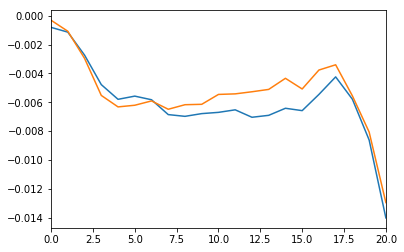

In [183]:
pd.DataFrame(con1).mean().plot()
pd.DataFrame(con2).mean().plot()


In [179]:
con1= []
con3 = []
for i in range(len(test)):
    try:
        start = dates.iloc[dates[dates['date']==test.iloc[i]['default_ann_date']].index-250]['date'].values[0]
        end = dates.iloc[dates[dates['date']==test.iloc[i]['default_ann_date']].index-15]['date'].values[0]
        post = dates.iloc[dates[dates['date']==test.iloc[i]['default_ann_date']].index+15]['date'].values[0]
        every = group.get_group(test.iloc[i]['industry_name'].decode('utf-8'))
        every['date'] = map(str,list(every['date']))
        ev= every[(every['date']>=start) & (every['date']<=end)]
        mkt = index[(index['date']>=start) & ((index['date']<=end))]
        ev1 =every[(every['date']>=end) & (every['date']<=test.iloc[i]['default_ann_date'])]
        mk1 = index[(index['date']>=end) & (index['date']<=test.iloc[i]['default_ann_date'])]
        indus = indu#indu[indu['code']!=test.iloc[i]['industry_name'].decode('utf-8')]
        indus['date'] = map(str,list(indus['date']))
        ot= indus[(indus['date']>=start) & (indus['date']<=end)]
        ot1 =indus[(indus['date']>=end) & (indus['date']<=test.iloc[i]['default_ann_date'])]
        gg = ev.groupby('indu')
        gg1 = ev1.groupby('indu')
        go = ot.groupby('indu')
        go1 = ot1.groupby('indu')
        res = []
        for k in gg.groups.keys():
            te = gg.get_group(k)
            te1 = gg1.get_group(k)
            beta = sm.OLS(np.array(te['ret']),sm.add_constant(np.array(mkt['ret']))).fit().params[1]
            res.append(pd.Series(np.array(te1['ret'])-np.array(mk1['ret'])*beta).cumsum())
        event = pd.DataFrame(res).mean()
        ress = []
        for m in go.groups.keys():
            toe =go.get_group(m)
            toe1 =go1.get_group(m)
            beta = sm.OLS(np.array(toe['ret']),sm.add_constant(np.array(mkt['ret']))).fit().params[1]
            ress.append(pd.Series(np.array(toe1['ret'])-np.array(mk1['ret'])*beta).cumsum())
        noevent = pd.DataFrame(ress).mean()
        con1.append(event)
        con3.append(noevent)
    except:
        pass

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [80]:
start = dates.iloc[dates[dates['date']==test.iloc[0]['default_ann_date']].index-270]['date'].values[0]
end = dates.iloc[dates[dates['date']==test.iloc[0]['default_ann_date']].index-30]['date'].values[0]

In [46]:
group.groups.keys()[0]

u'\u4f4f\u5bbf\u548c\u9910\u996e\u4e1a'

In [66]:
every = group.get_group(test.iloc[0]['industry_name'].decode('utf-8'))

In [73]:
every['date'] = map(str,list(every['date']))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [81]:
every['date'].iloc[0],start

('2015-01-05', u'2016-02-19')

In [84]:
ev= every[(every['date']>=start) & (every['date']<=end)]

In [114]:
mkt = index[(index['date']>=start) & ((index['date']<=end))]

In [127]:
ev1 =every[(every['date']>=end) & (every['date']<=test.iloc[0]['default_ann_date'])]
mk1 = index[(index['date']>=end) & (index['date']<=test.iloc[0]['default_ann_date'])]

In [134]:
%matplotlib inline

In [126]:
every['date'].iloc[0]

'2015-01-05'

In [92]:
import statsmodels.api as sm

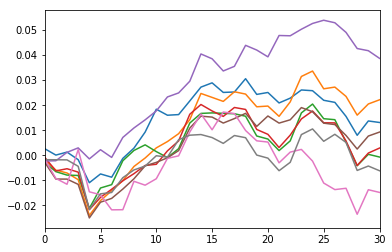

In [136]:
gg = ev.groupby('indu')
gg1 = ev1.groupby('indu')
for i in gg.groups.keys():
    te = gg.get_group(i)
    te1 = gg1.get_group(i)
    beta = sm.OLS(np.array(te['ret']),sm.add_constant(np.array(mkt['ret']))).fit().params[1]
    pd.Series(np.array(te1['ret'])-np.array(mk1['ret'])*beta).cumsum().plot()

In [55]:
test.iloc[0]['industry_name'].decode('utf-8')

u'\u5236\u9020\u4e1a'